In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import Sequential, load_model
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np
import math

In [2]:
df = pd.read_csv('preferred_study_environment.csv').drop(axis=1, columns=['Timestamp'])

In [4]:
df.head()

,Where do you prefer to study the most?,What motivates you most when choosing a study environment?,How important are noise levels in your study environment ?,How important is lighting in your study environment ?,"How important is the availability of resources (books, internet, etc.) in your study environment ?","How important is comfort (furniture, temperature) in your study environment?",How do you feel about studying in an environment where others are working or studying as well?,Do you prefer studying alone or with others?,At what time of the day do you usually study?
0,Cafe,Presence of other students for collaboration,3,3,5,4,Neutral,Alone,Evening
1,Home,"Availability of study resources (WiFi, computers)",5,3,3,5,Neutral,Alone,Evening
2,Home,Comfort and convenience,3,3,5,5,Neutral,Alone,Afternoon
3,Library,Comfort and convenience,5,3,5,5,Motivated,Alone,Afternoon
4,Home,Comfort and convenience,5,3,4,4,Distracted,Alone,Evening


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 9 columns):
 #   Column                                                                                              Non-Null Count  Dtype 
---  ------                                                                                              --------------  ----- 
 0   Where do you prefer to study the most?                                                              155 non-null    object
 1   What motivates you most when choosing a study environment?                                          155 non-null    object
 2   How important are noise levels in your study environment ?                                          155 non-null    int64 
 3   How important is lighting in your study environment ?                                               155 non-null    int64 
 4   How important is the availability of resources (books, internet, etc.) in your study environment ?  155 non-null    int64 


<h1>Data pre-processing</h1>

In [4]:
#Here i changed the columns names to make them more readable

new_names = {
    'Where do you prefer to study the most?' : 'study_environment',
    'What motivates you most when choosing a study environment?': 'motivation',
    'How important are noise levels in your study environment ?': 'noise_level',
    'How important is lighting in your study environment ?': 'lighting',
    'How important is the availability of resources (books, internet, etc.) in your study environment ?': 'resources',
    'How important is comfort (furniture, temperature) in your study environment?': 'comfort',
    'How do you feel about studying in an environment where others are working or studying as well?': 'environment_with_others',
    'Do you prefer studying alone or with others?': 'alone_or_with_others',
    'At what time of the day do you usually study?': 'study_time',
}
df.rename(columns=new_names, inplace=True)

In [7]:
print(f'No of NaN values: {sum(df.isna().sum())}')
print(f'No of Null values: {sum(df.isnull().sum())}')

No of NaN values: 0
No of Null values: 0


In [5]:
cat_features = [
    "motivation",
    "environment_with_others",
    "alone_or_with_others",
    "study_time"
]

x = df.drop(columns=["study_environment"])
y = df["study_environment"]

encoder = OneHotEncoder(sparse_output=False)
encoded_features = encoder.fit_transform(x[cat_features])

encoded_feature_names = encoder.get_feature_names_out(cat_features)

x = x.drop(columns=cat_features).reset_index(drop=True)
x = pd.concat([x, pd.DataFrame(encoded_features, columns=encoded_feature_names)], axis=1)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [9]:
x.describe()

,noise_level,lighting,resources,comfort,"motivation_Availability of study resources (WiFi, computers)",motivation_Comfort and convenience,motivation_Minimal distractions,motivation_Presence of other students for collaboration,environment_with_others_Distracted,environment_with_others_Motivated,environment_with_others_Neutral,alone_or_with_others_Alone,alone_or_with_others_In group sessions,alone_or_with_others_With friends,study_time_Afternoon,study_time_Evening,study_time_Morning
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,3.922581,3.696774,4.335484,4.070968,0.354839,0.380645,0.193548,0.070968,0.193548,0.367742,0.438710,0.709677,0.038710,0.251613,0.277419,0.483871,0.238710
std,1.230223,1.136034,0.995297,1.045148,0.480015,0.487119,0.396360,0.257603,0.396360,0.483754,0.497838,0.455383,0.193527,0.435347,0.449177,0.501360,0.427677
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,4.000000,5.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.500000,1.000000,1.000000,0.000000
max,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
for col in x.columns:
    print(f'{col}: {x[col].unique()}')

noise_level: [3 5 2 4 1]
lighting: [3 4 5 2 1]
resources: [5 3 4 2 1]
comfort: [4 5 3 2 1]
motivation_Availability of study resources (WiFi, computers): [0. 1.]
motivation_Comfort and convenience: [0. 1.]
motivation_Minimal distractions: [0. 1.]
motivation_Presence of other students for collaboration: [1. 0.]
environment_with_others_Distracted: [0. 1.]
environment_with_others_Motivated: [0. 1.]
environment_with_others_Neutral: [1. 0.]
alone_or_with_others_Alone: [1. 0.]
alone_or_with_others_In group sessions: [0. 1.]
alone_or_with_others_With friends: [0. 1.]
study_time_Afternoon: [0. 1.]
study_time_Evening: [1. 0.]
study_time_Morning: [0. 1.]


In [11]:
variances = x.var()
print('Variances:\n', variances)

Variances:
 noise_level                                                     1.513448
lighting                                                        1.290574
resources                                                       0.990616
comfort                                                         1.092333
motivation_Availability of study resources (WiFi, computers)    0.230415
motivation_Comfort and convenience                              0.237285
motivation_Minimal distractions                                 0.157101
motivation_Presence of other students for collaboration         0.066359
environment_with_others_Distracted                              0.157101
environment_with_others_Motivated                               0.234018
environment_with_others_Neutral                                 0.247842
alone_or_with_others_Alone                                      0.207373
alone_or_with_others_In group sessions                          0.037453
alone_or_with_others_With friends      

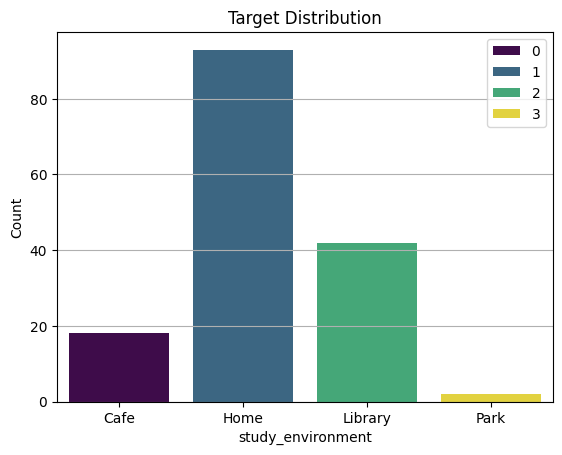

In [12]:
sns.countplot(x=y, hue=y, palette='viridis')
plt.xticks(ticks=[0, 1, 2, 3], labels=label_encoder.inverse_transform([0, 1, 2, 3]))
plt.title('Target Distribution')
plt.xlabel('study_environment')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

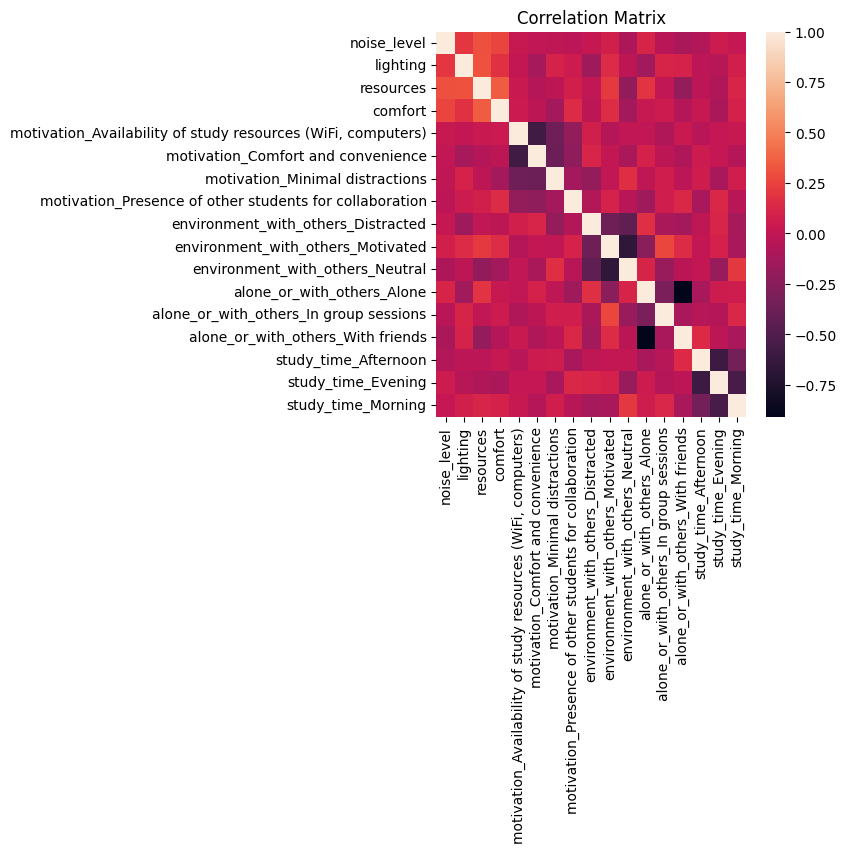

In [13]:
cor = x.corr()
plt.figure(figsize=(5, 5))
plt.title('Correlation Matrix')
sns.heatmap(cor)
plt.show()

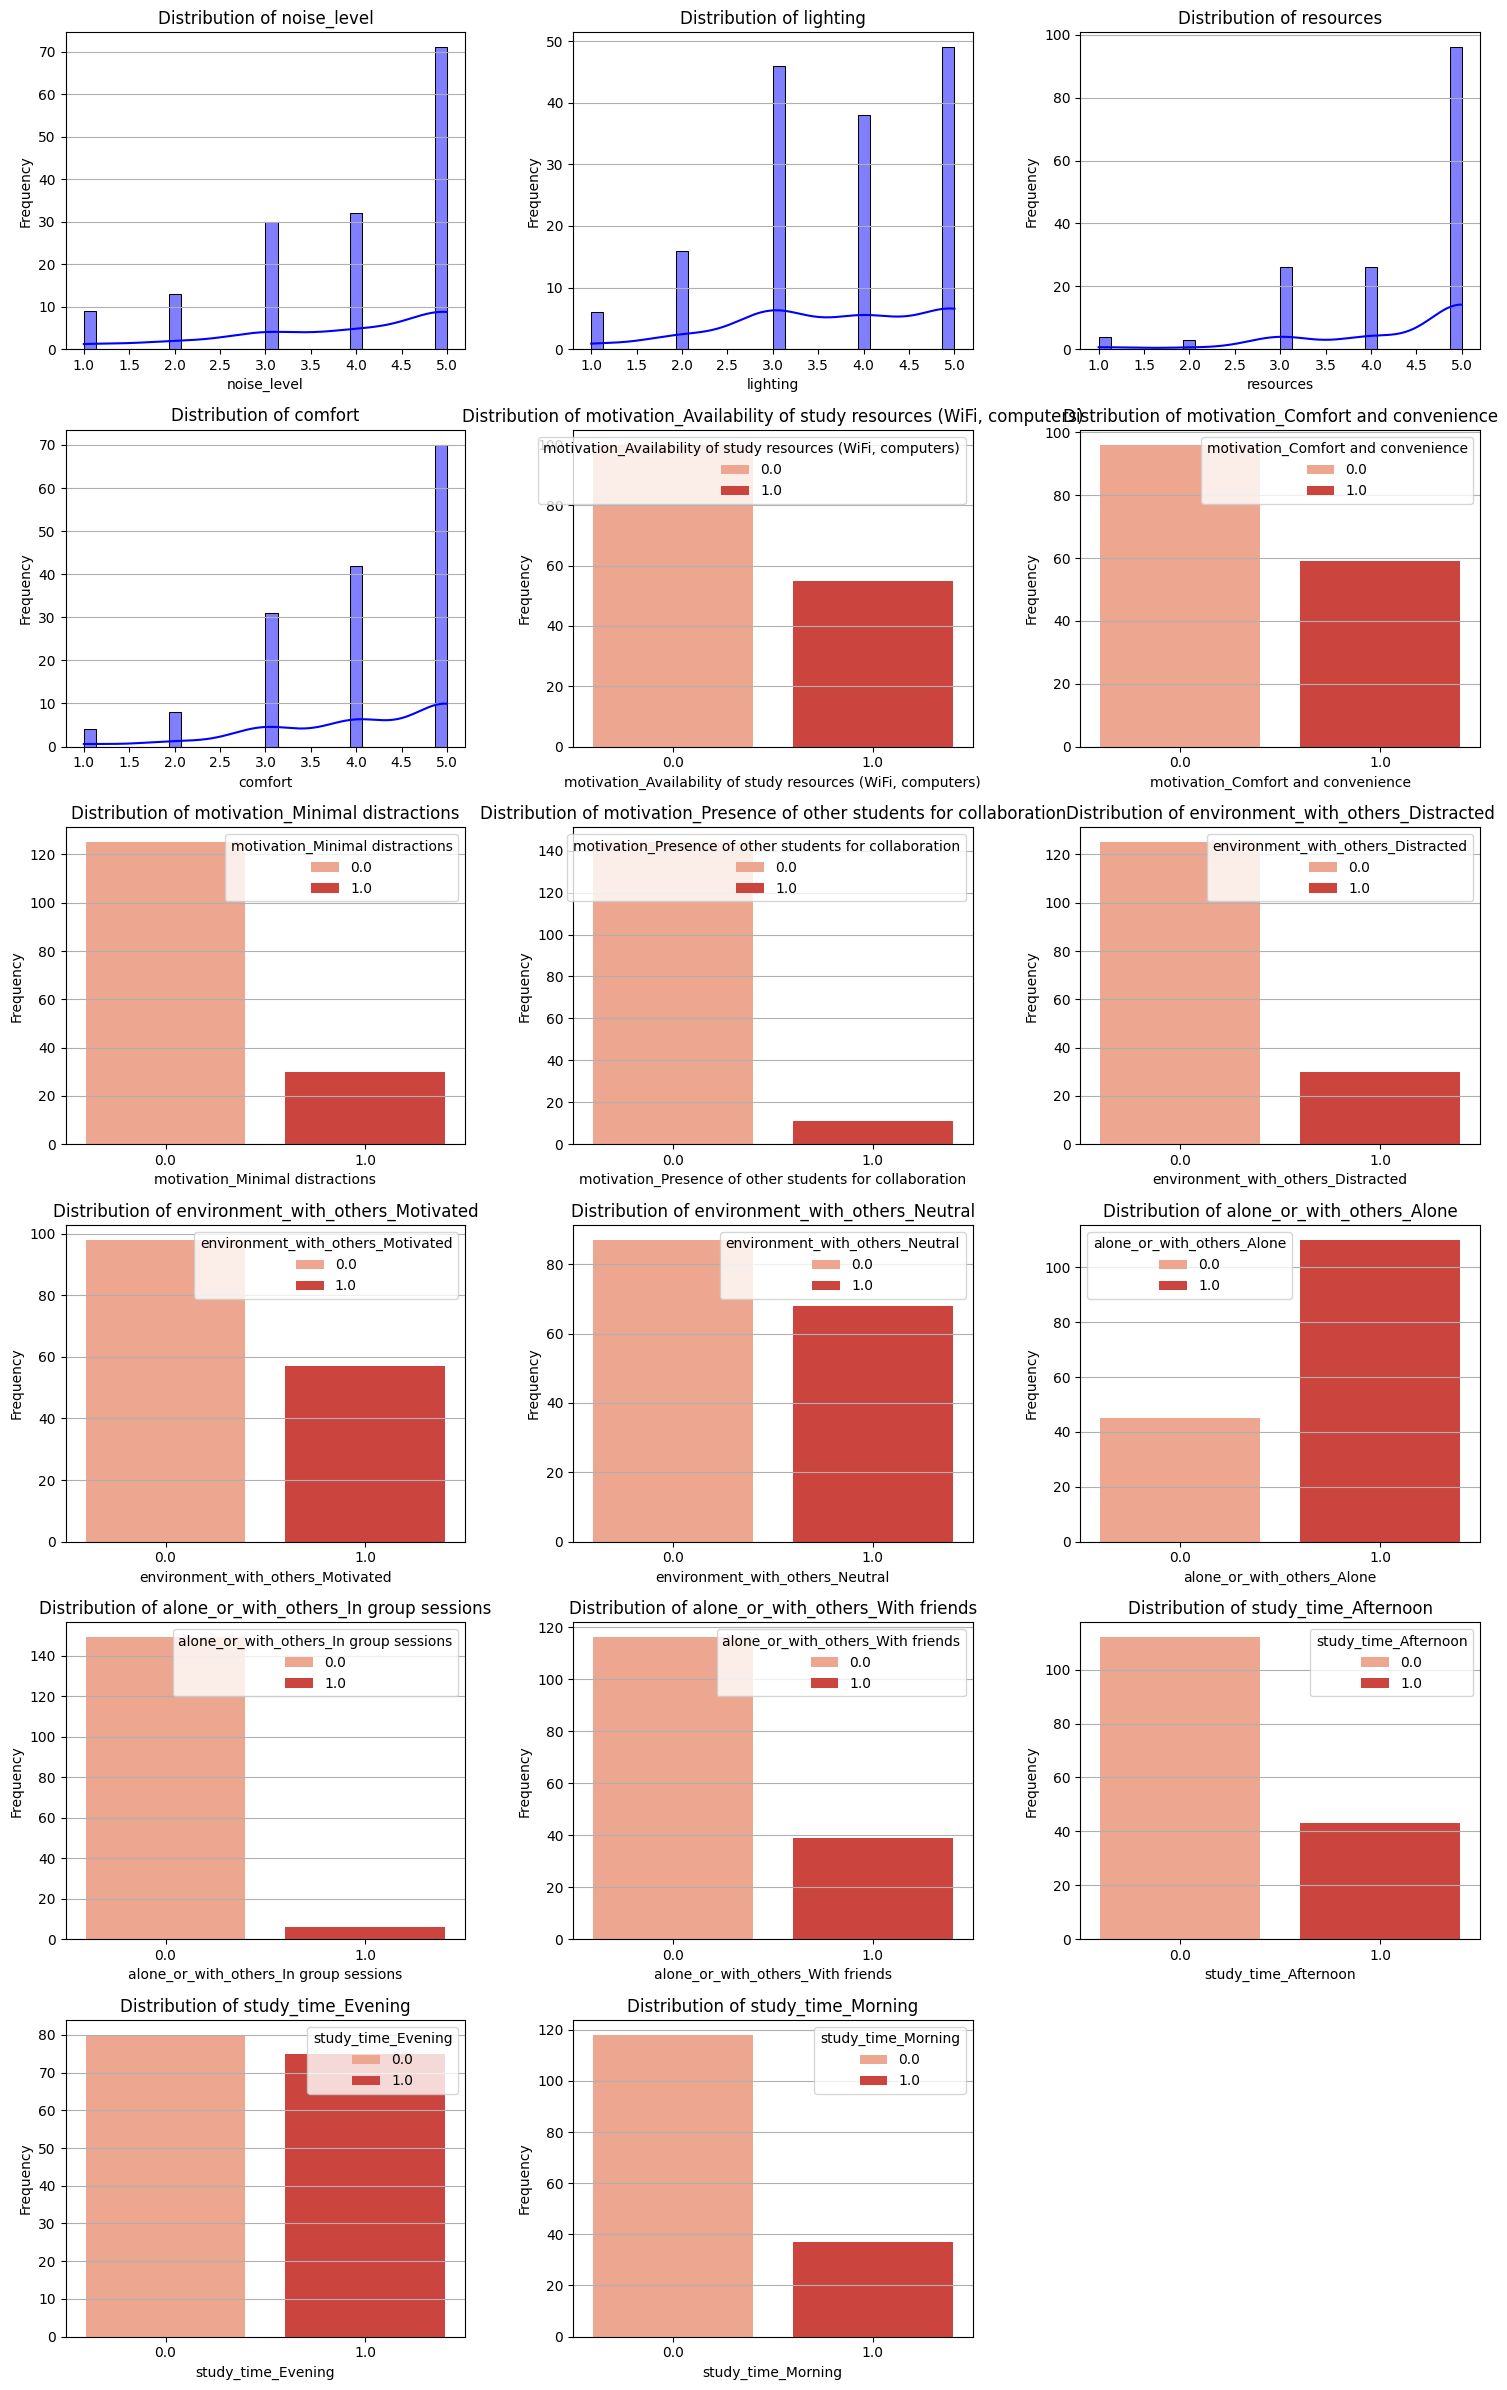

In [14]:
cols = x.columns
n = len(cols)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i in range(n):
    if len(x[cols[i]].unique()) <= 2:
        sns.countplot(data=x, x=cols[i], hue=cols[i] ,palette="Reds",ax=axes[i])
    else:
        sns.histplot(data=x, x=cols[i], kde=True, bins=30, color='blue', ax=axes[i])

    axes[i].set_title(f'Distribution of {cols[i]}')
    axes[i].set_xlabel(cols[i])
    axes[i].grid(axis='y')
    axes[i].set_ylabel('Frequency')

if n < len(axes):
    for i in range(n, len(axes)):
        fig.delaxes(axes[i])
        
plt.tight_layout()
plt.show()

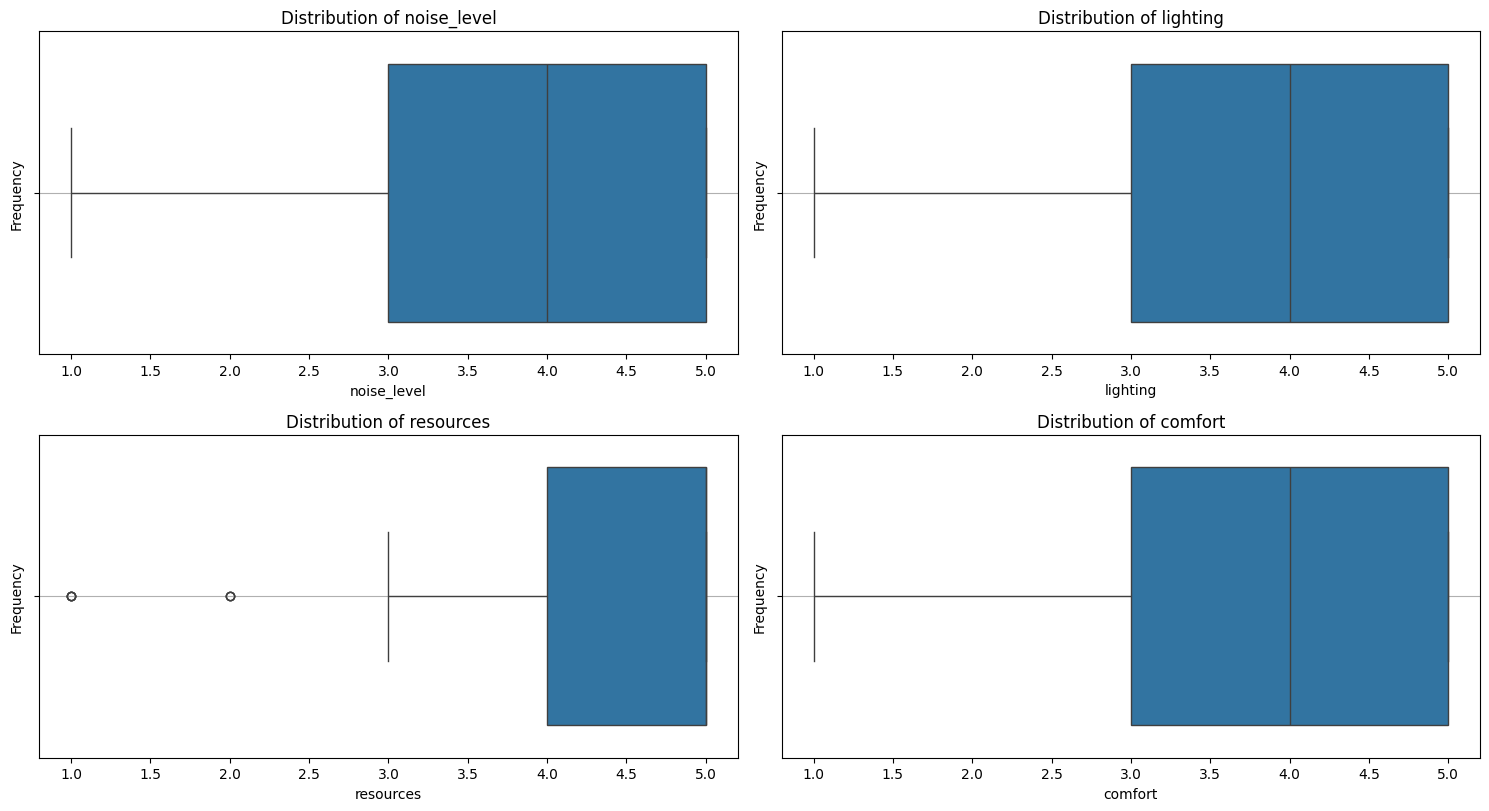

In [15]:
cols = x.columns[:-2]
n = len(cols)
n_cols = 2
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()

for i in range(4):
    sns.boxplot(data=x, x=cols[i], ax=axes[i])
    axes[i].set_title(f'Distribution of {cols[i]}')
    axes[i].set_xlabel(cols[i])
    axes[i].grid(axis='y')
    axes[i].set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [16]:
smote = SMOTE(random_state=42, k_neighbors=min(5, min(np.unique(y, return_counts=True)[1]) - 1))
x_resampled, y_resampled = smote.fit_resample(x, y)

In [ ]:
best_features_rfs = []
best_score = float('-inf')

for i in range(1, len(x_resampled.columns)):
    estimator = RandomForestClassifier()
    sfs = SequentialFeatureSelector(estimator, n_features_to_select=i, direction='forward')
    sfs.fit(x_resampled, y_resampled)
    
    selected_features = x_resampled.columns[sfs.get_support()]

    score = cross_val_score(estimator, x_resampled[selected_features], y_resampled, cv=5).mean()
    
    if score > best_score:
        best_score = score
        best_features_rfs = selected_features

x_selected = x_resampled[best_features_rfs]
print("Best features selected:", best_features_rfs)

In [18]:
best_features_rfs = ['noise_level', 'lighting', 'resources', 'comfort',
       'motivation_Comfort and convenience', 'motivation_Minimal distractions',
       'motivation_Presence of other students for collaboration',
       'environment_with_others_Distracted',
       'environment_with_others_Motivated', 'environment_with_others_Neutral',
       'alone_or_with_others_Alone', 'alone_or_with_others_In group sessions',
       'alone_or_with_others_With friends', 'study_time_Afternoon',
       'study_time_Morning']

x_selected = x_resampled[best_features_rfs]
# x_selected2 = x[best_features_rfs]
len(best_features_rfs)

15

In [19]:
x_train_resampled, x_test_resampled, y_train_resampled, y_test_resampled = train_test_split(x_selected, y_resampled, test_size=0.2, random_state=42)

<h1>Models training</h1>

In [20]:
reports_before = {}
reports_after = {}

In [21]:
reports_dicts_before = {}
reports_dicts_after = {}

In [22]:
accuracies_before = {}
accuracies_after = {}

<h3>Random Forests</h3>

In [23]:
forest = RandomForestClassifier(random_state=42)
forest.fit(x_train_resampled, y_train_resampled)
y_pred = forest.predict(x_test_resampled)
reports_before['rfs'] = classification_report(y_test_resampled, y_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]))
reports_dicts_before['rfs'] = classification_report(y_test_resampled, y_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]), output_dict=True)
acc = accuracy_score(y_test_resampled, y_pred)
accuracies_before['rfs'] = accuracy_score(y_test_resampled, y_pred)
acc

0.8266666666666667

In [26]:
rfs_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [18]:
forest_grid_search = GridSearchCV(RandomForestClassifier(), rfs_grid, cv=5, n_jobs=-1)
forest_grid_search.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [ ]:
rfs_pred = forest_grid_search.predict(x_test_resampled)
accuracy_score(y_test_resampled, rfs_pred)

In [42]:
best_forest = RandomForestClassifier(bootstrap=False, max_depth=90)
best_forest.fit(x_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=False, max_depth=90)

In [82]:
best_rfs_pred = best_forest.predict(x_test_resampled)
acc = accuracy_score(y_test_resampled, best_rfs_pred)
reports_after['rfs'] = classification_report(y_test_resampled, best_rfs_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]))
reports_dicts_after['rfs'] = classification_report(y_test_resampled, best_rfs_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]), output_dict=True)
accuracies_after['rfs'] = acc
acc

0.8266666666666667

In [41]:
cv_rfs = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rfs_score = cross_val_score(best_forest, x_selected, y_resampled, cv=cv_rfs)
print("Cross Validation Score:", cv_rfs_score.mean())

Cross Validation Score: 0.8576216216216217


<h3>Gradient Boosting

In [46]:
gbm = GradientBoostingClassifier(random_state=42)
gbm.fit(x_train_resampled, y_train_resampled)
gbm_pred = gbm.predict(x_test_resampled)
reports_before['gbm'] = classification_report(y_test_resampled, gbm_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]))
reports_dicts_before['gbm'] = classification_report(y_test_resampled, gbm_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]), output_dict=True)
acc = accuracy_score(y_test_resampled, gbm_pred)
accuracies_before['gbm'] = acc
acc

0.8133333333333334

In [51]:
gbm_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'learning_rate': [0.1, 0.01],
}

In [52]:
gbm = GridSearchCV(GradientBoostingClassifier(), gbm_grid, cv=5, n_jobs=-1)
gbm.fit(x_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [10, 20],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]})

In [ ]:
gbm_pred = gbm.predict(x_test_resampled)
reports_after['gbm'] = classification_report(y_test_resampled, gbm_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]))
reports_dicts_after['gbm'] = classification_report(y_test_resampled, gbm_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]), output_dict=True)
accuracy_score(y_test_resampled, gbm_pred)

In [57]:
best_gbm = GradientBoostingClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5)
best_gbm.fit(x_train_resampled, y_train_resampled)
gbm_pred = best_gbm.predict(x_test_resampled)
reports_after['gbm'] = classification_report(y_test_resampled, gbm_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]))
reports_dicts_after['gbm'] = classification_report(y_test_resampled, gbm_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]), output_dict=True)
acc = accuracy_score(y_test_resampled, gbm_pred)
accuracies_after['gbm'] = acc
acc

0.8266666666666667

In [58]:
gbm_cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_gbm_score = cross_val_score(best_gbm, x_selected, y_resampled, cv=gbm_cv)
print("Cross Validation Score:", cv_gbm_score.mean())

Cross Validation Score: 0.8335495495495495


<h3>Neural network

In [64]:
def create_ann_model(layers, start_number, dropout):
    ann_model = Sequential()
    ann_model.add(Dense(start_number, activation='relu', input_dim=x_train_resampled.shape[1]))
    
    for _ in range(layers - 1):
        ann_model.add(Dense(start_number // 2, activation='relu'))
        ann_model.add(Dropout(dropout))
        start_number //= 2
    
    ann_model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    ann_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return ann_model

In [69]:
ann_model_before = create_ann_model(2, 128, 0.2)

/home/ibrahem/Desktop/win_desktop/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [70]:
ann_model_before.fit(x_train_resampled, y_train_resampled, epochs=75, validation_split=0.2, batch_size=32)
# ann_model_before.save("ann_model_before.h5")

Epoch 1/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.3043 - loss: 1.4342 - val_accuracy: 0.2667 - val_loss: 1.3649
Epoch 2/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3772 - loss: 1.3045 - val_accuracy: 0.4500 - val_loss: 1.3113
Epoch 3/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5189 - loss: 1.2307 - val_accuracy: 0.5000 - val_loss: 1.2379
Epoch 4/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5463 - loss: 1.1922 - val_accuracy: 0.5667 - val_loss: 1.1881
Epoch 5/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5583 - loss: 1.1402 - val_accuracy: 0.5500 - val_loss: 1.1422
Epoch 6/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5554 - loss: 1.0946 - val_accuracy: 0.5667 - val_loss: 1.0826
Epoch 7/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5638 - loss: 1.0521 - val_accuracy: 0.5500 - val_loss: 1.0567
Epoch 8/75
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5788 - loss: 1.0317 - val_accuracy: 0.6000 - val_loss: 0.9972


In [71]:
loss, accuracy = ann_model_before.evaluate(x_test_resampled, y_test_resampled)
y_pred = ann_model_before.predict(x_test_resampled).argmax(axis=1)
reports_before['ann'] = classification_report(y_test_resampled, y_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]))
reports_dicts_before['ann'] = classification_report(y_test_resampled, y_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]), output_dict=True)
accuracies_before['ann'] = accuracy
print(f"Test Accuracy: {accuracy:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8313 - loss: 0.4198
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7867281d2200> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Test Accuracy: 0.83


In [41]:
ann_grid = {
    'hidden_layers': [1, 2, 3, 4],
    'start_number': [64, 128, 256, 512],
    'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
    'epochs': [50, 75, 100], 
}

In [ ]:
best_acc = float('-inf')
best_model_params = None

for i in ann_grid['hidden_layers']:
    for j in ann_grid['start_number']:
        for k in ann_grid['dropout']:
            for l in ann_grid['epochs']:
                model = create_ann_model(i, j, k)
                model.fit(x_train_resampled, y_train_resampled, epochs=l, validation_split=0.2, batch_size=32, verbose=0)
                _, accuracy = model.evaluate(x_test_resampled, y_test_resampled)
                if accuracy > best_acc:
                    best_acc = accuracy
                    best_model_params = {'hidden_layers': i, 'start_number': j, 'dropout': k, 'epochs': l}

/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7417 - loss: 0.7255


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7801 - loss: 0.6177


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7695 - loss: 0.5525


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7511 - loss: 0.7010


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7879 - loss: 0.6033


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8168 - loss: 0.5700


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7589 - loss: 0.7124


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7879 - loss: 0.5828


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7589 - loss: 0.5400


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7561 - loss: 0.7012


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7589 - loss: 0.6519


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7879 - loss: 0.5699


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7127 - loss: 0.6676


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7695 - loss: 0.6364


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7906 - loss: 0.5520


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8090 - loss: 0.6127


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7984 - loss: 0.5134


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8274 - loss: 0.5114


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7984 - loss: 0.6190


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7984 - loss: 0.5407


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7867 - loss: 0.5026


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7405 - loss: 0.6276


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8274 - loss: 0.5605


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7879 - loss: 0.5339


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7734 - loss: 0.6353


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8168 - loss: 0.5685


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8352 - loss: 0.4961


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7589 - loss: 0.6088


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8458 - loss: 0.5095


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8168 - loss: 0.4773


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8090 - loss: 0.5761


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7984 - loss: 0.5064


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8708 - loss: 0.4233


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8380 - loss: 0.5815


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8419 - loss: 0.4862


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8458 - loss: 0.4622


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8274 - loss: 0.5654


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8747 - loss: 0.4426


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8051 - loss: 0.5064


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8352 - loss: 0.5495


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7695 - loss: 0.5068


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8168 - loss: 0.4830


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7667 - loss: 0.5709


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8274 - loss: 0.4782


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8341 - loss: 0.4358


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8168 - loss: 0.5101


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8630 - loss: 0.4335


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8708 - loss: 0.4024


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8274 - loss: 0.4903


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8524 - loss: 0.4446


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8524 - loss: 0.4040


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8090 - loss: 0.4968


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8524 - loss: 0.4219


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8708 - loss: 0.3840


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8274 - loss: 0.5098


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8603 - loss: 0.4191


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8524 - loss: 0.4080


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8274 - loss: 0.4927


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9104 - loss: 0.4136


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8708 - loss: 0.4043


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7511 - loss: 0.6312


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8129 - loss: 0.4545


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8430 - loss: 0.4354


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7249 - loss: 0.6682


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8564 - loss: 0.4802


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8023 - loss: 0.5421


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8062 - loss: 0.5676


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7879 - loss: 0.5262


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8051 - loss: 0.5090


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7233 - loss: 0.7024


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7695 - loss: 0.5667


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7722 - loss: 0.5922


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7433 - loss: 0.6814


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7405 - loss: 0.6210


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8090 - loss: 0.5019


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8262 - loss: 0.4537


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8207 - loss: 0.4744


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8998 - loss: 0.3524


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8446 - loss: 0.4702


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8814 - loss: 0.3612


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8446 - loss: 0.3899


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8196 - loss: 0.4733


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8736 - loss: 0.3751


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8708 - loss: 0.3719


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8090 - loss: 0.4848


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8341 - loss: 0.4311


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8023 - loss: 0.4927


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8603 - loss: 0.4630


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7945 - loss: 0.5140


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8708 - loss: 0.4189


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8603 - loss: 0.3925


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8603 - loss: 0.4254


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8419 - loss: 0.3946


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8630 - loss: 0.3941


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8235 - loss: 0.3689


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8524 - loss: 0.4182


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8920 - loss: 0.3911


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8262 - loss: 0.4551


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8524 - loss: 0.4603


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8023 - loss: 0.4795


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8235 - loss: 0.4063


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8419 - loss: 0.3843


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8168 - loss: 0.4592


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8235 - loss: 0.4227


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8786 - loss: 0.2999


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8391 - loss: 0.3914


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8023 - loss: 0.6519


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8419 - loss: 0.6665


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8708 - loss: 0.3911


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8341 - loss: 0.4913


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8603 - loss: 0.5499


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8708 - loss: 0.3606


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8497 - loss: 0.4441


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8708 - loss: 0.4472


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8497 - loss: 0.4009


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8341 - loss: 0.4388


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8708 - loss: 0.5160


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8524 - loss: 0.3940


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8157 - loss: 0.4206


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8524 - loss: 0.4661


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6943 - loss: 0.6827


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8313 - loss: 0.3956


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8552 - loss: 0.4397


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8090 - loss: 0.4902


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8446 - loss: 0.5116


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8446 - loss: 0.4704


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7221 - loss: 0.6323


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8141 - loss: 0.5427


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7945 - loss: 0.4793


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7233 - loss: 0.7810


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6982 - loss: 0.6874


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8630 - loss: 0.4643


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7311 - loss: 0.7473


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7561 - loss: 0.7060


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6877 - loss: 0.7987


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7840 - loss: 0.4904


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8207 - loss: 0.4071


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8708 - loss: 0.4239


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7906 - loss: 0.4912


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8708 - loss: 0.4045


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8235 - loss: 0.4961


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7879 - loss: 0.5456


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8524 - loss: 0.4459


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8630 - loss: 0.3563


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7561 - loss: 0.5596


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7840 - loss: 0.4745


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8920 - loss: 0.4408


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7957 - loss: 0.5840


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7495 - loss: 0.5466


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8235 - loss: 0.4902


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8524 - loss: 0.3848


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8446 - loss: 0.4338


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8708 - loss: 0.5263


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8497 - loss: 0.4086


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8419 - loss: 0.4900


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8708 - loss: 0.4031


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8736 - loss: 0.4277


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8603 - loss: 0.4414


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8419 - loss: 0.5786


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8274 - loss: 0.4443


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8736 - loss: 0.3815


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8419 - loss: 0.4618


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8062 - loss: 0.4823


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8341 - loss: 0.4314


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8129 - loss: 0.4436


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8708 - loss: 0.5633


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8313 - loss: 0.6529


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8524 - loss: 0.6540


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8814 - loss: 0.4638


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8892 - loss: 0.5599


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8524 - loss: 0.6031


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8419 - loss: 0.4127


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8736 - loss: 0.3921


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8446 - loss: 0.5694


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8207 - loss: 0.4710


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7840 - loss: 0.6921


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8313 - loss: 0.6627


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8313 - loss: 0.4572


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8630 - loss: 0.4228


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7945 - loss: 0.7416


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7651 - loss: 0.8005


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7761 - loss: 0.4957


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8826 - loss: 0.4229


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7929 - loss: 0.6933


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6392 - loss: 0.8014


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7761 - loss: 0.5920


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7010 - loss: 0.7065


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6180 - loss: 0.8217


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6403 - loss: 0.8176


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6720 - loss: 1.2263


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6297 - loss: 0.9554


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7143 - loss: 0.9349


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6665 - loss: 1.0163


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5479 - loss: 1.1368


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4744 - loss: 1.1210


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7656 - loss: 0.5424


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8497 - loss: 0.4658


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8814 - loss: 0.4740


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8074 - loss: 0.5543


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8235 - loss: 0.4499


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8497 - loss: 0.3490


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6904 - loss: 0.6472


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7879 - loss: 0.5104


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8497 - loss: 0.4556


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6364 - loss: 0.7592


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8157 - loss: 0.6225


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8603 - loss: 0.4635


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6219 - loss: 0.8903


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6180 - loss: 0.8561


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6877 - loss: 0.6612


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8419 - loss: 0.4627


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8736 - loss: 0.4025


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9393 - loss: 0.2655


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8129 - loss: 0.5134


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8341 - loss: 0.5250


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8630 - loss: 0.5386


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8391 - loss: 0.4679


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8419 - loss: 0.4088


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8603 - loss: 0.4480


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7617 - loss: 0.6144


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7840 - loss: 0.4783


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8708 - loss: 0.3356


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6916 - loss: 0.7511


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8141 - loss: 0.4284


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8207 - loss: 0.4308


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8235 - loss: 0.5500


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8786 - loss: 0.5920


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8419 - loss: 0.6208


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8524 - loss: 0.4765


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8207 - loss: 0.4741


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8708 - loss: 0.7843


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8341 - loss: 0.4689


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8524 - loss: 0.4965


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8497 - loss: 0.7087


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7761 - loss: 0.4740


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8524 - loss: 0.4139


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8708 - loss: 0.7428


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8341 - loss: 0.5259


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8446 - loss: 0.4456


/home/ibrahem/os/Users/oioil/سطح المكتب/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8235 - loss: 0.6138


In [20]:
best_model_params

{'hidden_layers': 4, 'start_number': 256, 'dropout': 0.1, 'epochs': 100}

In [29]:
new_ann = create_ann_model(4, 256, 0.1)
new_ann.fit(x_train_resampled, y_train_resampled, epochs=100, validation_split=0.2, batch_size=32)

/home/ibrahem/Desktop/win_desktop/Uni/ML/Project/myenv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - accuracy: 0.2878 - loss: 1.3981 - val_accuracy: 0.4833 - val_loss: 1.3227
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4151 - loss: 1.3249 - val_accuracy: 0.4667 - val_loss: 1.2459
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4923 - loss: 1.2537 - val_accuracy: 0.5833 - val_loss: 1.1514
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5111 - loss: 1.1813 - val_accuracy: 0.6500 - val_loss: 1.0503
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5582 - loss: 1.0914 - val_accuracy: 0.6500 - val_loss: 0.9844
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6165 - loss: 0.9763 - val_accuracy: 0.6167 - val_loss: 0.8888
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5943 - loss: 0.9445 - val_accuracy: 0.6167 - val_loss: 0.8335
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6001 - loss: 0.8630 - val_accuracy: 0.6667 - val_loss:

In [ ]:
new_ann.save("new_ann_model.keras")

In [ ]:
ann_model = load_model("new_ann_model.keras")

In [73]:
_, accuracy = ann_model.evaluate(x_test_resampled, y_test_resampled)
y_pred = ann_model.predict(x_test_resampled).argmax(axis=1)
reports_after['ann'] = classification_report(y_test_resampled, y_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]))
reports_dicts_after['ann'] = classification_report(y_test_resampled, y_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]), output_dict=True)
accuracies_after['ann'] = accuracy
accuracy

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8998 - loss: 0.3881 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


0.8933333158493042

<h1>Stacking

In [74]:
class StackingModel(LogisticRegression):
    def __init__(self, models, penalty='l1', solver='liblinear', max_iter=100, **kwargs):
        super().__init__(penalty=penalty, solver=solver, max_iter=max_iter, **kwargs)
        self.models = models

    def prep_stacking_data(self, x):
        data = []
        for model in self.models:
            data.append(model.predict(x))

        return np.column_stack(data)
    
    def fit(self, x, y):
        x_stacked = self.prep_stacking_data(x)
        super().fit(x_stacked, y)

    def predict(self, x):
        x_stacked = self.prep_stacking_data(x=x)
        return super().predict(x_stacked)
    
    def predict_proba(self, x):
        x_stacked = self.prep_stacking_data(x=x)
        return super().predict_proba(x_stacked)


In [75]:
stacking_model = StackingModel(models=[ann_model, best_gbm, best_forest])
stacking_model.fit(x=x_train_resampled, y=y_train_resampled)

 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [77]:
stacking_pred = stacking_model.predict(x_test_resampled)
reports_before['stacking'] = ''
reports_dicts_before['stacking'] = ''
reports_after['stacking'] = classification_report(y_test_resampled, stacking_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]))
reports_dicts_after['stacking'] = classification_report(y_test_resampled, stacking_pred, target_names=label_encoder.inverse_transform([0, 1, 2, 3]), output_dict=True)
accuracies_before['stacking'] = 0
acc = accuracy_score(y_test_resampled, stacking_pred)
accuracies_after['stacking'] = acc
acc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


0.88

<h1>Comparasion

In [83]:
trained_models = {
    'rfs': best_forest,
    'gbm': best_gbm,
    'stacking': stacking_model,
    'ann': ann_model
}

In [79]:
aucs = {}
for model_name, model in trained_models.items():
    y_pred = model.predict(x_test_resampled)

    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(x_test_resampled)
    elif hasattr(model, "decision_function"):
        y_pred_prob = model.decision_function(x_test_resampled)
    else:
        y_pred_prob = None 
    
    if y_pred_prob is not None:
        y_pred = y_pred_prob.argmax(axis=1)  

    auc = None
    if y_pred_prob is not None:
        auc = roc_auc_score(y_test_resampled, y_pred_prob, multi_class='ovr') 
    
    aucs[model_name] = auc

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [84]:
for model in accuracies_before:
    print(f"Results for {model}:")
    print(f"Accuracy Before Hyperparameter tuning: {accuracies_before[model]:.2f}")
    print(f"Accuracy After Hyperparameter tuning: {accuracies_after[model]:.2f}")
    print(f"AUC: {aucs[model]}")
    print("Classification Report Before Hyperparameter tuning:")
    print(reports_before[model])
    print("Classification Report After Hyperparameter tuning:")
    print(reports_after[model])

Results for rfs:
Accuracy Before Hyperparameter tuning: 0.83
Accuracy After Hyperparameter tuning: 0.83
AUC: 0.9535876623376622
Classification Report Before Hyperparameter tuning:
              precision    recall  f1-score   support

        Cafe       1.00      0.79      0.88        19
        Home       0.70      0.70      0.70        20
     Library       0.70      0.84      0.76        19
        Park       1.00      1.00      1.00        17

    accuracy                           0.83        75
   macro avg       0.85      0.83      0.84        75
weighted avg       0.84      0.83      0.83        75

Classification Report After Hyperparameter tuning:
              precision    recall  f1-score   support

        Cafe       0.94      0.79      0.86        19
        Home       0.75      0.75      0.75        20
     Library       0.68      0.79      0.73        19
        Park       1.00      1.00      1.00        17

    accuracy                           0.83        75
   macro

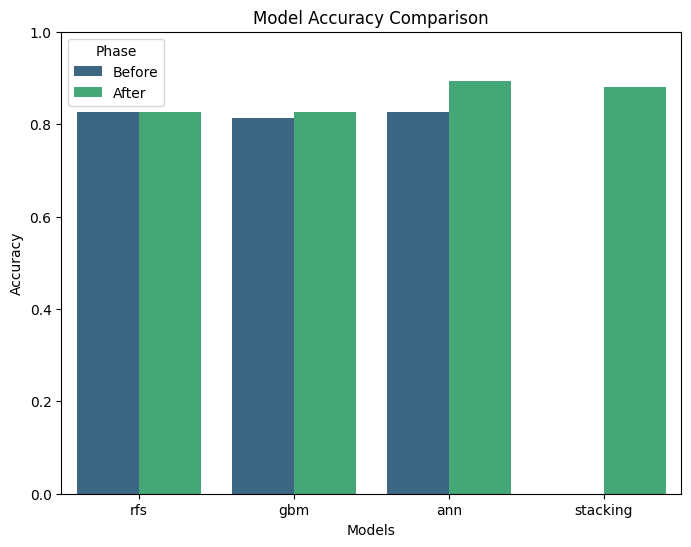

In [85]:
models = list(accuracies_after.keys())
data = {
    "Model": models * 2,
    "Accuracy": list(accuracies_before.values()) + list(accuracies_after.values()),
    "Phase": ["Before"] * len(models) + ["After"] * len(models),
}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.barplot(x="Model", y='Accuracy', data=df, palette="viridis", hue='Phase')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.ylim(0, 1)
plt.show()

Confusion Matrix for rfs


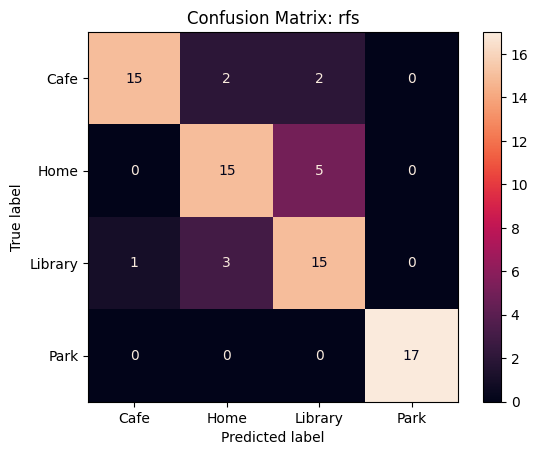

Confusion Matrix for gbm


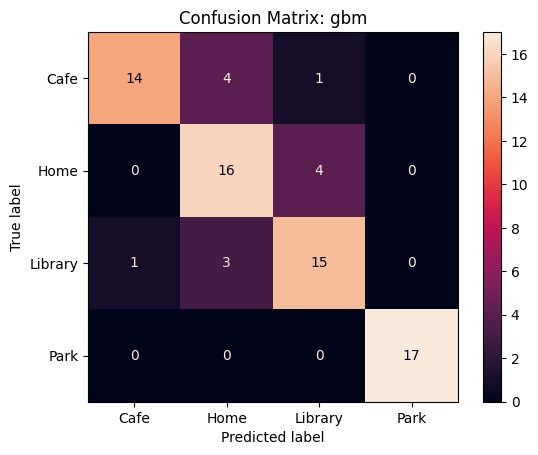

Confusion Matrix for stacking
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


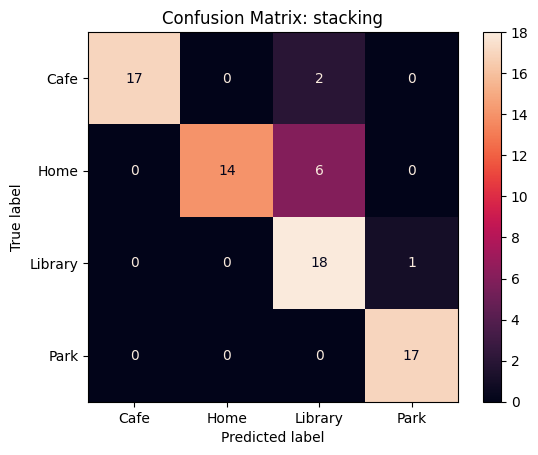

Confusion Matrix for ann
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


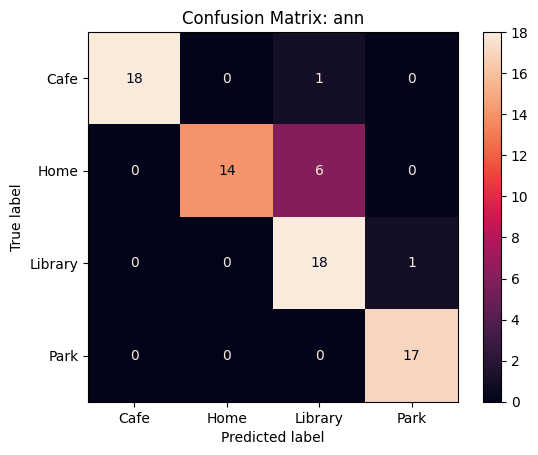

In [86]:
for model_name, model in trained_models.items():
    print(f"Confusion Matrix for {model_name}")
    y_pred = model.predict(x_test_resampled)
    if hasattr(model, "predict_proba"):
        y_pred = model.predict_proba(x_test_resampled).argmax(axis=1)
    elif model_name == 'ann':
        y_pred = y_pred.argmax(axis=1)
    
    disp = ConfusionMatrixDisplay.from_predictions(y_test_resampled, y_pred, display_labels=label_encoder.classes_, cmap='rocket')
    disp.ax_.set_title(f"Confusion Matrix: {model_name}")
    plt.show()


<h1>Unsupervised learning

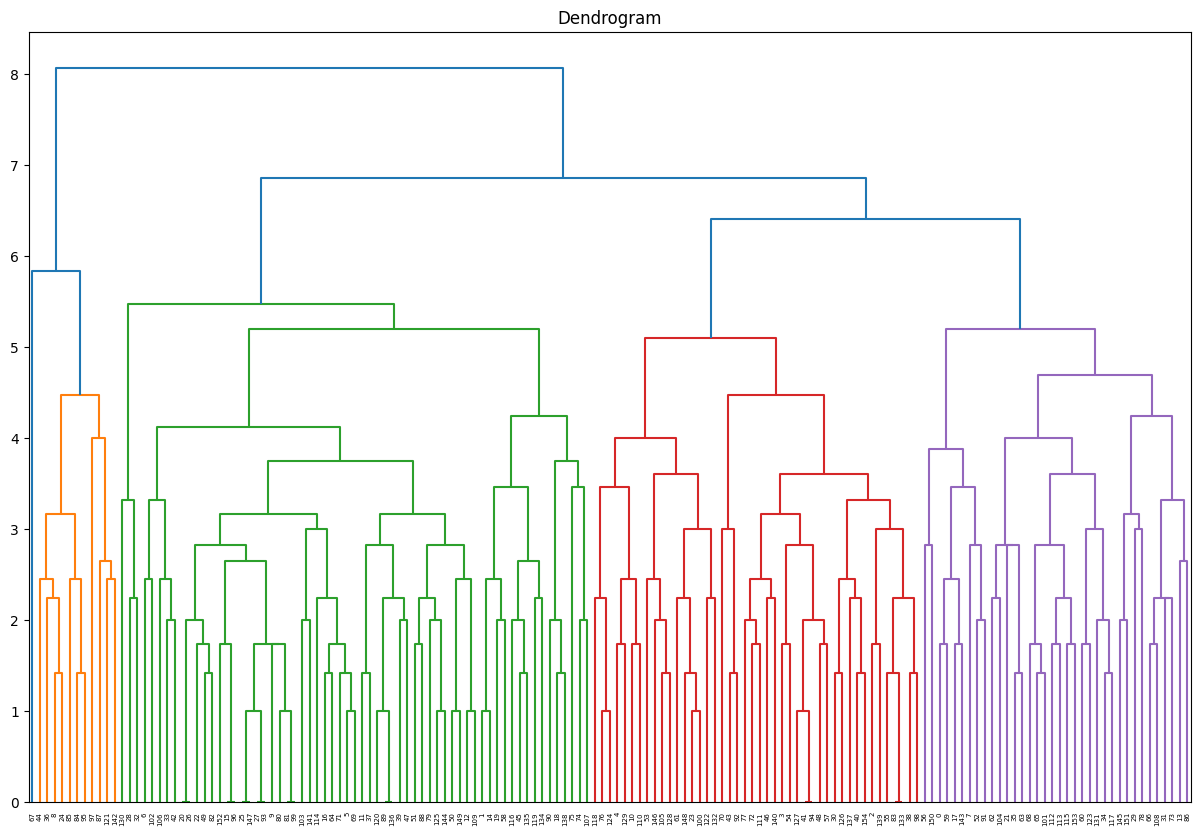

In [11]:
x_df = pd.DataFrame(x, columns=x.columns)
linkage_matrix = linkage(x_df, method='complete', metric='euclidean')
plt.figure(figsize=(15, 10))
dendrogram(linkage_matrix, labels=x_df.index, leaf_rotation=90)
plt.title('Dendrogram')
plt.show()

In [12]:
num_clusters = 4
x_df['cluster_labels'] = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

x_df['cluster_labels'].value_counts()

cluster_labels
2    63
3    44
4    36
1    12
Name: count, dtype: int64

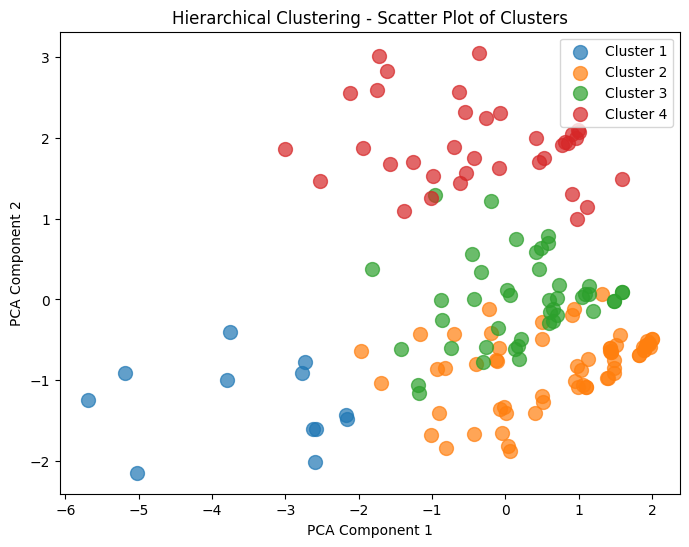

In [13]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_df)

plt.figure(figsize=(8, 6))
for cluster in np.unique(x_df['cluster_labels']):
    cluster_points = x_pca[x_df['cluster_labels'] == cluster]
    plt.scatter(
        cluster_points[:, 0], cluster_points[:, 1],
        label=f'Cluster {cluster}', s=100, alpha=0.7
    )

plt.title("Hierarchical Clustering - Scatter Plot of Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()